In [3]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import layers, losses, utils
print(tf.__version__)

2.18.0


#Sentiment Analysis

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

In [4]:
dataset = utils.get_file("aclImdb_v1", url, untar=True, cache_dir=".", cache_subdir="")

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 27s 0us/step


In [5]:
dataset_dir = "/content/aclImdb_v1/aclImdb"

In [6]:
os.listdir(dataset_dir)

['README', 'train', 'test', 'imdb.vocab', 'imdbEr.txt']

In [8]:
train_dir = os.path.join(dataset_dir, "train")

os.listdir(train_dir)

['unsupBow.feat',
 'urls_pos.txt',
 'pos',
 'unsup',
 'urls_neg.txt',
 'labeledBow.feat',
 'urls_unsup.txt',
 'neg']

In [9]:
sample_file = os.path.join(train_dir,"pos/1181_9.txt")

In [11]:
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [12]:
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)

In [13]:
batch_size=32
seed= 42


raw_train_ds= utils.text_dataset_from_directory(train_dir, batch_size=batch_size, validation_split=0.25, subset="training", seed=seed)

Found 25000 files belonging to 2 classes.
Using 18750 files for training.


In [15]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Label", label_batch.numpy()[i])
    print("Review", text_batch.numpy()[i])
    print(" ")
    print(" ")


Label 1
Review b"Having seen most of Ringo Lam's films, I can say that this is his best film to date, and the most unusual. It's a ancient china period piece cranked full of kick-ass martial arts, where the location of an underground lair full of traps and dungeons plays as big a part as any of the characters. The action is fantastic, the story is tense and entertaining, and the set design is truely memorable. Sadly, Burning Paradise has not been made available on DVD and vhs is next-to-impossible to get your mitts on, even if you near the second biggest china-town in North America (like I do). If you can find it, don't pass it up."
 
 
Label 1
Review b'Caution: May contain spoilers...<br /><br />I\'ve seen this movie 3 times & I\'ve liked it every time. Upon seeing it again, I\'m always reminded of how good it is. An HBO TV movie- very well done like most of their movies are- this would\'ve gotten Oscars for it\'s performances had it been released for general distribution instead of m

In [16]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [17]:
raw_val_ds = utils.text_dataset_from_directory(train_dir, validation_split=0.25, subset="validation", batch_size=batch_size, seed=seed)

Found 25000 files belonging to 2 classes.
Using 6250 files for validation.


In [18]:
raw_test_ds = utils.text_dataset_from_directory(os.path.join(dataset_dir, "test"), batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [19]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)

  stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
  return tf.strings.regex_replace(stripped_html, "[%s]" % re.escape(string.punctuation), "")

In [20]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features,
    output_mode = "int",
    output_sequence_length = sequence_length
)

In [21]:
train_text = raw_train_ds.map(lambda x, y:x)
vectorize_layer.adapt(train_text)

In [22]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [23]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  261,    2,  221,    1,  583,   30,  228,   11, 2470,
           1,   51,   22,   25,  403,  251,   12,  310,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [24]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  disappointing
 313 --->  american
Vocabulary size: 10000


In [25]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
embedding_dim = 16

In [28]:
model = tf.keras.Sequential(
    [
        layers.Embedding(max_features, embedding_dim),
        layers.Dropout(0.2),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),

    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.compile(optimizer="adam", loss = losses.BinaryCrossentropy(), metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

In [30]:
epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - binary_accuracy: 0.5810 - loss: 0.6828 - val_binary_accuracy: 0.7482 - val_loss: 0.6209
Epoch 2/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.7507 - loss: 0.5905 - val_binary_accuracy: 0.8094 - val_loss: 0.5096
Epoch 3/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - binary_accuracy: 0.8197 - loss: 0.4790 - val_binary_accuracy: 0.8352 - val_loss: 0.4326
Epoch 4/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - binary_accuracy: 0.8448 - loss: 0.4056 - val_binary_accuracy: 0.8464 - val_loss: 0.3872
Epoch 5/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - binary_accuracy: 0.8646 - loss: 0.3570 - val_binary_accuracy: 0.8589 - val_loss: 0.3585
Epoch 6/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.8786 - loss: 0.3239 - val_binary_accuracy: 0.8638 - val_loss: 0.3386
Epoch 7/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.8851 - loss: 0.2994 - val_binary_accuracy: 0.8696 - val_loss: 0.3245
Epo

In [31]:
loss, accuracy = model.evaluate(test_ds)

print("loss: ", loss)
print("accuracy: ", accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.8691 - loss: 0.3157
loss:  0.3177378177642822
accuracy:  0.8692799806594849


In [32]:
history_dict = history.history

history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

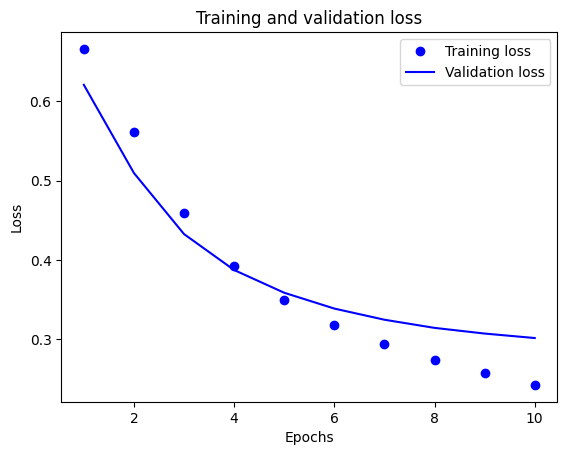

In [33]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

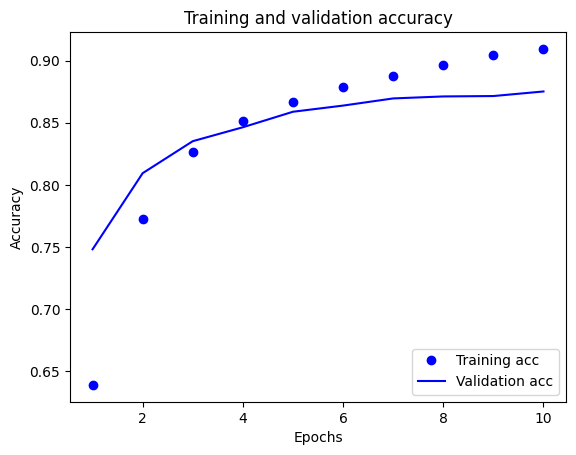

In [34]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [35]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
metrics = export_model.evaluate(raw_test_ds, return_dict=True)
print(metrics)

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5012 - loss: 0.5899
{'accuracy': 0.5, 'loss': 0.5907648205757141}


In [36]:
examples = tf.constant([
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
])

export_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


array([[0.6611448 ],
       [0.61894125],
       [0.5973443 ]], dtype=float32)